In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

In [2]:
# set pandas to display all columns
pd.set_option('display.max_columns', None)

#### 1. Data Preprocessing

In [3]:
# define the path to the file
file_path = 'data/tool_sensor_data.csv'

# read the csv file
df = pd.read_csv(file_path)

# rename column
column_dict = {
    'TimeStamp': 'timestamp',
    'ToolName': 'tool_name',
    'TOOL_ID': 'tool_id',
    'Run': 'run',
    'RunStartTime': 'run_start_time',
    'DATA_QUALITY': 'data_quality',
    'EQPType': 'eqp_type',
    'HasComments': 'has_comments',
    'LOT_ID': 'lot_id',
    'LogicalRecipeID': 'logical_recipe_id',
    'LotPurposeType': 'lot_purpose_type',
    'LotType': 'lot_type',
    'MachineRecipeID': 'machine_recipe_id',
    'PhysicalRecipeID': 'physical_recipe_id',
    'PortID': 'port_id',
    'ProcessOpNum': 'process_op_num',
    'ProductGrpID': 'product_grp_id',
    'ProductID': 'product_id',
    'RECIPE_ID': 'recipe_id',
    'ReticleID': 'reticle_id',
    'RouteID': 'route_id',
    'Technology': 'technology',
    'WAFER_ID': 'wafer_id',
    'EventType': 'event_type',
    'EventName': 'event_name',
    'EventId': 'event_id',
    'EventSource': 'event_source',
    'EventDescription': 'event_description',
    'AlarmCode': 'alarm_code',
    'AlarmStatus': 'alarm_status',
    'CalcStepSeq': 'calc_step_seq',
    'CalcLoopSeq': 'calc_loop_seq',
    'RunTag': 'run_tag',
    'Unnamed: 85': 'unnamed_85',
    'Unnamed: 86': 'unnamed_86',
    'Unnamed: 87': 'unnamed_87',
    'Unnamed: 88': 'unnamed_88',
    'Unnamed: 89': 'unnamed_89'
}
columns_not_in_dict = [col for col in df.columns if col not in column_dict.keys()]
columns_not_in_dict = {col: f'tool_sensor_{i + 1}' for i, col in enumerate(columns_not_in_dict) if col not in column_dict.keys()}

merged_dict = {**column_dict, **columns_not_in_dict}

df.rename(columns = merged_dict, inplace = True)

# display top 10 rows
df.head(10)

,timestamp,tool_name,tool_id,run,run_start_time,data_quality,eqp_type,has_comments,lot_id,logical_recipe_id,lot_purpose_type,lot_type,machine_recipe_id,physical_recipe_id,port_id,process_op_num,product_grp_id,product_id,recipe_id,reticle_id,route_id,technology,wafer_id,tool_sensor_1,tool_sensor_2,tool_sensor_3,tool_sensor_4,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_22,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_27,tool_sensor_28,tool_sensor_29,tool_sensor_30,tool_sensor_31,tool_sensor_32,tool_sensor_33,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_41,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,tool_sensor_46,event_type,event_name,event_id,event_source,event_description,alarm_code,alarm_status,tool_sensor_47,tool_sensor_48,tool_sensor_49,tool_sensor_50,tool_sensor_51,tool_sensor_52,calc_step_seq,calc_loop_seq,run_tag,unnamed_85,unnamed_86,unnamed_87,unnamed_88,unnamed_89
0,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,StartOfRun,WaferStart,WaferStart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,56.0,0.98,1.0,1.0,0.71,306.0,119.0,129.0,145.0,125.0,3.0,3.0,0.0,7.00,5.85,0.00,9.49,13.0,99.0,6.46,0.0,0.0,0.0,0.00,98.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,0.0,0.0,0.0,0.0,0.74,2.0,500.0,81.0,-25.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,148.0,0.98,1.0,1.0,3.76,308.0,119.0,128.0,144.0,123.0,-72.0,3.0,0.0,7.00,5.84,0.00,9.49,968.0,111.0,16.03,127.0,0.0,0.0,0.00,200.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,12.0,5.0,1304.0,3110.0,0.74,7.0,300.0,81.0,1890.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,12.0,0.98,1.0,1.0,4.17,307.0,120.0,128.0,144.0,123.0,-72.0,3.0,0.2,6.83,5.85,0.01,9.63,968.0,111.0,16.06,127.0,0.0,35.0,4.04,206.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,8.0,4.0,1305.0,3107.0,0.74,8.0,300.0,81.0,1890.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,19.0,0.98,1.0,1.0,4.44,307.0,119.0,127.0,144.0,123.0,-72.0,3.0,1.8,7.00,6.45,0.61,9.49,968.0,111.0,16.06,86.0,0.0,40.0,7.05,199.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1251.0,0.0,6.0,3.0,1302.0,3104.0,0.74,9.0,6200.0,81.0,1890.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
5,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,100.0,0.98,1.0,1.0,4.66,307.0,119.0,127.0,145.0,123.0,-72.0,3.0,0.7,7.00,6.33,0.49,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.15,201.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2651.0,63.0,4.0,2.0,1302.0,3103.0,0.74,11.0,1400.0,81.0,1890.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
6,21/3/2023 19:15,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,140.0,0.98,1.0,1.0,4.92,331.0,119.0,127.0,145.0,124.0,-73.0,3.0,0.0,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,6.0,11.0,5.0,13

In [4]:
# display the shape of the dataframe
print(f"there are total {df.shape[0]} rows, and {df.shape[1]} columns")

there are total 14844 rows, and 90 columns


In [5]:
# visualize dataset description
dataset_description = df.describe()
dataset_description

,run,data_quality,has_comments,reticle_id,wafer_id,tool_sensor_1,tool_sensor_2,tool_sensor_3,tool_sensor_4,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_22,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_27,tool_sensor_28,tool_sensor_29,tool_sensor_30,tool_sensor_31,tool_sensor_32,tool_sensor_33,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_41,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,tool_sensor_46,event_source,event_description,alarm_code,alarm_status,tool_sensor_47,tool_sensor_48,tool_sensor_49,tool_sensor_50,tool_sensor_51,tool_sensor_52,calc_step_seq,calc_loop_seq,run_tag,unnamed_85,unnamed_86,unnamed_87,unnamed_88,unnamed_89
count,14844.000000,14844.000000,14844.0,0.0,14844.000000,14388.000000,1.438800e+04,14388.0,14388.0,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.00000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.0,14388.000000,14388.000000,14388.000000,14388.000000,1.438800e+04,14388.0,14388.0,14388.0,14388.0,14388.0,14388.0,14388.000000,14388.00000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,1.438800e+04,14616.000000,14388.000000,14388.000000,14388.000000,14388.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14616.000000,14616.000000,0.0,0.0,0.0,0.0,0.0,0.0
mean,62437.529103,70.762264,0.0,NaN,12.707154,115.818807,9.800000e-01,1.0,1.0,5.817178,357.031902,119.584306,128.832013,144.414790,131.818668,-64.933208,3.031485,0.721768,6.99517,6.295957,0.447252,9.487216,793.013970,105.060676,15.189718,119.680289,0.0,45.704615,7.798031,204.472130,2.319363,7.380000e-01,0.0,0.0,0.0,0.0,0.0,0.0,4988.246733,2003.24854,4.106686,6.471574,3.615582,1175.201001,2741.521407,7.400000e-01,13.456897,25574.117320,96.026967,1838.558173,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.289135,6.289135,NaN,NaN,NaN,NaN,NaN,NaN
std,90.607731,15.702130,0.0,NaN,7.111389,54.891018,3.330785e-16,0.0,0.0,5.575780,29.851953,0.800654,2.971084,8.829543,6.194255,33.729107,0.427290,4.350116,0.12156,0.770134,0.769185,0.076229,363.044767,23.890697,3.507948,46.542424,0.0,30.753165,4.941302,24.192323,0.123312,2.220523e-16,0.0,0.0,0.0,0.0,0.0,0.0,90.586950,1226.93936,10.558384,10.973962,7.816805,326.913416,830.014541,1.110262e-16,5.247933,23817.306287,10.470464,304.102331,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.097085,3.097085,NaN,NaN,NaN,NaN,NaN,NaN
min,62301.000000,42.330000,0.0,NaN,1.000000,10.000000,9.800000e-01,1.0,1.0,0.410000,293.000000,118.000000,120.000000,117.000000,119.000000,-512.000000,1.000000,0.000000,3.26000,4.320000,0.000000,7.030000,10.000000,0.000000,0.060000,0.000000,0.0,0.000000,0.000000,82.000000,2.130000,7.380000e-01,0.0,0.0,0.0,0.0,0.0,0.0,4852.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,7.400000e-01,-2.000000,0.000000,81.000000,-25.000000,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,62359.000000,58.560000,0.0,NaN,6.750000,91.000000,9.800000e-01,1.0,1.0,4.420000,330.000000,119.000000,126.000000,140.000000,126.000000,-83.000000,3.000000,0.000000,7.00000,6.200000,0.310000,9.490000,952.000000,111.000000,16.030000,106.000000,0.0,18.000000,3.812500,203.000000,2.170000,7.380000e-01,0.0,0.0,0.0,0.0,0.0,0.0,4910.000000,38.75000,0.000000,5.000000,2.000000,1302.000000,3103.000000,7.400000e-01,11.000000,3600.000000,87.000000,1890.000000,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,62408.000000,63.890000,0.0,NaN,13.000000,144.000000,9.800000e-01,1.0,1.0,4.920000,366.000000,120.000000,129.000000,146.000000,134.000000,-78.000000,3.000000,0.400000,7.00000,6.290000,0.450000,9.49

In [6]:
# set pandas to display all rows
pd.set_option('display.max_rows', None)

# find missing (na) values
na_values = df.isna().sum()

print(na_values)

timestamp                 0
tool_name                 0
tool_id                   0
run                       0
run_start_time            0
data_quality              0
eqp_type                  0
has_comments              0
lot_id                    0
logical_recipe_id         0
lot_purpose_type          0
lot_type                  0
machine_recipe_id         0
physical_recipe_id        0
port_id                   0
process_op_num            0
product_grp_id            0
product_id                0
recipe_id                 0
reticle_id            14844
route_id                  0
technology                0
wafer_id                  0
tool_sensor_1           456
tool_sensor_2           456
tool_sensor_3           456
tool_sensor_4           456
tool_sensor_5           456
tool_sensor_6           456
tool_sensor_7           456
tool_sensor_8           456
tool_sensor_9           456
tool_sensor_10          456
tool_sensor_11          456
tool_sensor_12          456
tool_sensor_13      

In [7]:
# columns with exactly 14844 missing values
columns_with_14844_na = na_values[na_values == 14844].index.tolist()

# print the list of columns
print(columns_with_14844_na)

['reticle_id', 'event_source', 'event_description', 'alarm_code', 'alarm_status', 'tool_sensor_47', 'tool_sensor_48', 'tool_sensor_49', 'tool_sensor_50', 'tool_sensor_51', 'tool_sensor_52', 'run_tag', 'unnamed_85', 'unnamed_86', 'unnamed_87', 'unnamed_88', 'unnamed_89']


In [8]:
# check for columns with 14388 NA values and their unique values
columns_with_14388_na = na_values[na_values == 14388].index.tolist()

for column in columns_with_14388_na:
    # get unique values of the column
    unique_values = df[column].unique()
    print(f"unique values in '{column}':", unique_values)

unique values in 'event_type': ['StartOfRun' nan 'EndOfRun']
unique values in 'event_name': ['WaferStart' nan 'WaferEnd']
unique values in 'event_id': ['WaferStart' nan 'WaferEnd']


In [9]:
# drop columns with 14844 N/A and 14388 N/A
columns_to_drop = columns_with_14844_na + columns_with_14388_na
df.drop(columns = columns_to_drop, inplace = True)

df.head(10)

,timestamp,tool_name,tool_id,run,run_start_time,data_quality,eqp_type,has_comments,lot_id,logical_recipe_id,lot_purpose_type,lot_type,machine_recipe_id,physical_recipe_id,port_id,process_op_num,product_grp_id,product_id,recipe_id,route_id,technology,wafer_id,tool_sensor_1,tool_sensor_2,tool_sensor_3,tool_sensor_4,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_22,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_27,tool_sensor_28,tool_sensor_29,tool_sensor_30,tool_sensor_31,tool_sensor_32,tool_sensor_33,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_41,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,tool_sensor_46,calc_step_seq,calc_loop_seq
0,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,56.0,0.98,1.0,1.0,0.71,306.0,119.0,129.0,145.0,125.0,3.0,3.0,0.0,7.00,5.85,0.00,9.49,13.0,99.0,6.46,0.0,0.0,0.0,0.00,98.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,0.0,0.0,0.0,0.0,0.74,2.0,500.0,81.0,-25.0,75.0,1.0,1.0
2,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,148.0,0.98,1.0,1.0,3.76,308.0,119.0,128.0,144.0,123.0,-72.0,3.0,0.0,7.00,5.84,0.00,9.49,968.0,111.0,16.03,127.0,0.0,0.0,0.00,200.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,12.0,5.0,1304.0,3110.0,0.74,7.0,300.0,81.0,1890.0,75.0,2.0,2.0
3,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,12.0,0.98,1.0,1.0,4.17,307.0,120.0,128.0,144.0,123.0,-72.0,3.0,0.2,6.83,5.85,0.01,9.63,968.0,111.0,16.06,127.0,0.0,35.0,4.04,206.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,8.0,4.0,1305.0,3107.0,0.74,8.0,300.0,81.0,1890.0,75.0,3.0,3.0
4,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,19.0,0.98,1.0,1.0,4.44,307.0,119.0,127.0,144.0,123.0,-72.0,3.0,1.8,7.00,6.45,0.61,9.49,968.0,111.0,16.06,86.0,0.0,40.0,7.05,199.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1251.0,0.0,6.0,3.0,1302.0,3104.0,0.74,9.0,6200.0,81.0,1890.0,75.0,4.0,4.0
5,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,100.0,0.98,1.0,1.0,4.66,307.0,119.0,127.0,145.0,123.0,-72.0,3.0,0.7,7.00,6.33,0.49,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.15,201.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2651.0,63.0,4.0,2.0,1302.0,3103.0,0.74,11.0,1400.0,81.0,1890.0,75.0,5.0,5.0
6,21/3/2023 19:15,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,140.0,0.98,1.0,1.0,4.92,331.0,119.0,127.0,145.0,124.0,-73.0,3.0,0.0,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,6.0,11.0,5.0,1304.0,3110.0,0.74,11.0,9800.0,81.0,1890.0,75.0,5.0,5.0
7,21/3/2023 19:15,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,145.0,0.98,1.0,1.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,0.74,11.0,11300.0,81.0,1890.0,75.0,5.0,5.0
8,21/3/2023 19:15,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,145.0,0.98,1.0,1.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,0.74,11.0,11300.0,81.0,1890.0,75.0,5.0,5.0
9,21/

In [10]:
# removing rows that still have missing values after drop certain columns
# criteria > 227
rows_to_drop = na_values[na_values > 227].index.tolist()

rows_to_drop_set = set(rows_to_drop)
columns_to_drop_set = set(columns_to_drop)

filtered_rows_to_drop = rows_to_drop_set - columns_to_drop_set
filtered_rows_to_drop = list(filtered_rows_to_drop)

df.dropna(subset = filtered_rows_to_drop, inplace = True)

In [11]:
# stored in a format that is machine-readable, so can do time-based filtering, grouping,
# and plotting later in your analysis
df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%d/%m/%Y %H:%M')
df['run_start_time'] = pd.to_datetime(df['run_start_time'], format = '%I:%M:%S %p').dt.time

df.head(10)

,timestamp,tool_name,tool_id,run,run_start_time,data_quality,eqp_type,has_comments,lot_id,logical_recipe_id,lot_purpose_type,lot_type,machine_recipe_id,physical_recipe_id,port_id,process_op_num,product_grp_id,product_id,recipe_id,route_id,technology,wafer_id,tool_sensor_1,tool_sensor_2,tool_sensor_3,tool_sensor_4,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_22,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_27,tool_sensor_28,tool_sensor_29,tool_sensor_30,tool_sensor_31,tool_sensor_32,tool_sensor_33,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_41,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,tool_sensor_46,calc_step_seq,calc_loop_seq
1,2023-03-21 19:14:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,56.0,0.98,1.0,1.0,0.71,306.0,119.0,129.0,145.0,125.0,3.0,3.0,0.0,7.00,5.85,0.00,9.49,13.0,99.0,6.46,0.0,0.0,0.0,0.00,98.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,0.0,0.0,0.0,0.0,0.74,2.0,500.0,81.0,-25.0,75.0,1.0,1.0
2,2023-03-21 19:14:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,148.0,0.98,1.0,1.0,3.76,308.0,119.0,128.0,144.0,123.0,-72.0,3.0,0.0,7.00,5.84,0.00,9.49,968.0,111.0,16.03,127.0,0.0,0.0,0.00,200.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,12.0,5.0,1304.0,3110.0,0.74,7.0,300.0,81.0,1890.0,75.0,2.0,2.0
3,2023-03-21 19:14:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,12.0,0.98,1.0,1.0,4.17,307.0,120.0,128.0,144.0,123.0,-72.0,3.0,0.2,6.83,5.85,0.01,9.63,968.0,111.0,16.06,127.0,0.0,35.0,4.04,206.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,8.0,4.0,1305.0,3107.0,0.74,8.0,300.0,81.0,1890.0,75.0,3.0,3.0
4,2023-03-21 19:14:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,19.0,0.98,1.0,1.0,4.44,307.0,119.0,127.0,144.0,123.0,-72.0,3.0,1.8,7.00,6.45,0.61,9.49,968.0,111.0,16.06,86.0,0.0,40.0,7.05,199.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1251.0,0.0,6.0,3.0,1302.0,3104.0,0.74,9.0,6200.0,81.0,1890.0,75.0,4.0,4.0
5,2023-03-21 19:14:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,100.0,0.98,1.0,1.0,4.66,307.0,119.0,127.0,145.0,123.0,-72.0,3.0,0.7,7.00,6.33,0.49,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.15,201.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2651.0,63.0,4.0,2.0,1302.0,3103.0,0.74,11.0,1400.0,81.0,1890.0,75.0,5.0,5.0
6,2023-03-21 19:15:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,140.0,0.98,1.0,1.0,4.92,331.0,119.0,127.0,145.0,124.0,-73.0,3.0,0.0,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,6.0,11.0,5.0,1304.0,3110.0,0.74,11.0,9800.0,81.0,1890.0,75.0,5.0,5.0
7,2023-03-21 19:15:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,145.0,0.98,1.0,1.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,0.74,11.0,11300.0,81.0,1890.0,75.0,5.0,5.0
8,2023-03-21 19:15:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,145.0,0.98,1.0,1.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,0.74,11.0,11300.0,81.0,1890.0,75.0,5.0,5.0
9,2023-03-21 19:15:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,11.0,0.98,1.0,1.0,4.94,347.0,119.0,127.0,146.0,125.0,-73.0,3.0,0.0,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2802.0,4.0,11.0

In [12]:
# removing columns with only one unique value
for column in df.columns:
    print(f"total unique values in '{column}':", len(df[column].unique()))

columns_to_drop = [column for column in df.columns if df[column].nunique() == 1]

df.drop(columns = columns_to_drop, inplace = True)

total unique values in 'timestamp': 894
total unique values in 'tool_name': 1
total unique values in 'tool_id': 1
total unique values in 'run': 228
total unique values in 'run_start_time': 222
total unique values in 'data_quality': 110
total unique values in 'eqp_type': 1
total unique values in 'has_comments': 1
total unique values in 'lot_id': 23
total unique values in 'logical_recipe_id': 1
total unique values in 'lot_purpose_type': 1
total unique values in 'lot_type': 1
total unique values in 'machine_recipe_id': 2
total unique values in 'physical_recipe_id': 2
total unique values in 'port_id': 2
total unique values in 'process_op_num': 6
total unique values in 'product_grp_id': 14
total unique values in 'product_id': 16
total unique values in 'recipe_id': 2
total unique values in 'route_id': 12
total unique values in 'technology': 5
total unique values in 'wafer_id': 25
total unique values in 'tool_sensor_1': 156
total unique values in 'tool_sensor_2': 1
total unique values in 'too

In [13]:
# check after dropping columns and rows
df.isna().sum()

timestamp             0
run                   0
run_start_time        0
data_quality          0
lot_id                0
machine_recipe_id     0
physical_recipe_id    0
port_id               0
process_op_num        0
product_grp_id        0
product_id            0
recipe_id             0
route_id              0
technology            0
wafer_id              0
tool_sensor_1         0
tool_sensor_5         0
tool_sensor_6         0
tool_sensor_7         0
tool_sensor_8         0
tool_sensor_9         0
tool_sensor_10        0
tool_sensor_11        0
tool_sensor_12        0
tool_sensor_13        0
tool_sensor_14        0
tool_sensor_15        0
tool_sensor_16        0
tool_sensor_17        0
tool_sensor_18        0
tool_sensor_19        0
tool_sensor_20        0
tool_sensor_21        0
tool_sensor_23        0
tool_sensor_24        0
tool_sensor_25        0
tool_sensor_26        0
tool_sensor_34        0
tool_sensor_35        0
tool_sensor_36        0
tool_sensor_37        0
tool_sensor_38  

#### 2. Exploratory Data Analysis

2.1. Time Series Analytics (Tool Sensor)

In [14]:
df.head(10)

,timestamp,run,run_start_time,data_quality,lot_id,machine_recipe_id,physical_recipe_id,port_id,process_op_num,product_grp_id,product_id,recipe_id,route_id,technology,wafer_id,tool_sensor_1,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,calc_step_seq,calc_loop_seq
1,2023-03-21 19:14:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,56.0,0.71,306.0,119.0,129.0,145.0,125.0,3.0,3.0,0.0,7.00,5.85,0.00,9.49,13.0,99.0,6.46,0.0,0.0,0.00,98.0,2.47,4852.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,500.0,81.0,-25.0,1.0,1.0
2,2023-03-21 19:14:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,148.0,3.76,308.0,119.0,128.0,144.0,123.0,-72.0,3.0,0.0,7.00,5.84,0.00,9.49,968.0,111.0,16.03,127.0,0.0,0.00,200.0,2.47,4852.0,1.0,0.0,12.0,5.0,1304.0,3110.0,7.0,300.0,81.0,1890.0,2.0,2.0
3,2023-03-21 19:14:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,12.0,4.17,307.0,120.0,128.0,144.0,123.0,-72.0,3.0,0.2,6.83,5.85,0.01,9.63,968.0,111.0,16.06,127.0,35.0,4.04,206.0,2.47,4852.0,1.0,0.0,8.0,4.0,1305.0,3107.0,8.0,300.0,81.0,1890.0,3.0,3.0
4,2023-03-21 19:14:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,19.0,4.44,307.0,119.0,127.0,144.0,123.0,-72.0,3.0,1.8,7.00,6.45,0.61,9.49,968.0,111.0,16.06,86.0,40.0,7.05,199.0,2.47,4852.0,1251.0,0.0,6.0,3.0,1302.0,3104.0,9.0,6200.0,81.0,1890.0,4.0,4.0
5,2023-03-21 19:14:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,100.0,4.66,307.0,119.0,127.0,145.0,123.0,-72.0,3.0,0.7,7.00,6.33,0.49,9.49,968.0,111.0,16.06,106.0,49.0,9.15,201.0,2.47,4852.0,2651.0,63.0,4.0,2.0,1302.0,3103.0,11.0,1400.0,81.0,1890.0,5.0,5.0
6,2023-03-21 19:15:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,140.0,4.92,331.0,119.0,127.0,145.0,124.0,-73.0,3.0,0.0,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,6.0,11.0,5.0,1304.0,3110.0,11.0,9800.0,81.0,1890.0,5.0,5.0
7,2023-03-21 19:15:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,145.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,11.0,11300.0,81.0,1890.0,5.0,5.0
8,2023-03-21 19:15:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,145.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,11.0,11300.0,81.0,1890.0,5.0,5.0
9,2023-03-21 19:15:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,11.0,4.94,347.0,119.0,127.0,146.0,125.0,-73.0,3.0,0.0,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2802.0,4.0,11.0,5.0,1306.0,3108.0,11.0,14500.0,81.0,1890.0,5.0,5.0
10,2023-03-21 19:15:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,11.0,4.94,353.0,119.0,127.0,146.0,125.0,-74.0,3.0,0.2,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2803.0,4.0,12.0,5.0,1304.0,3108.0,11.0,16900.0,81.0,1890.0,5.0,5.0


In [15]:
# check uniqueness of timestamp
len(df["timestamp"].unique())

894

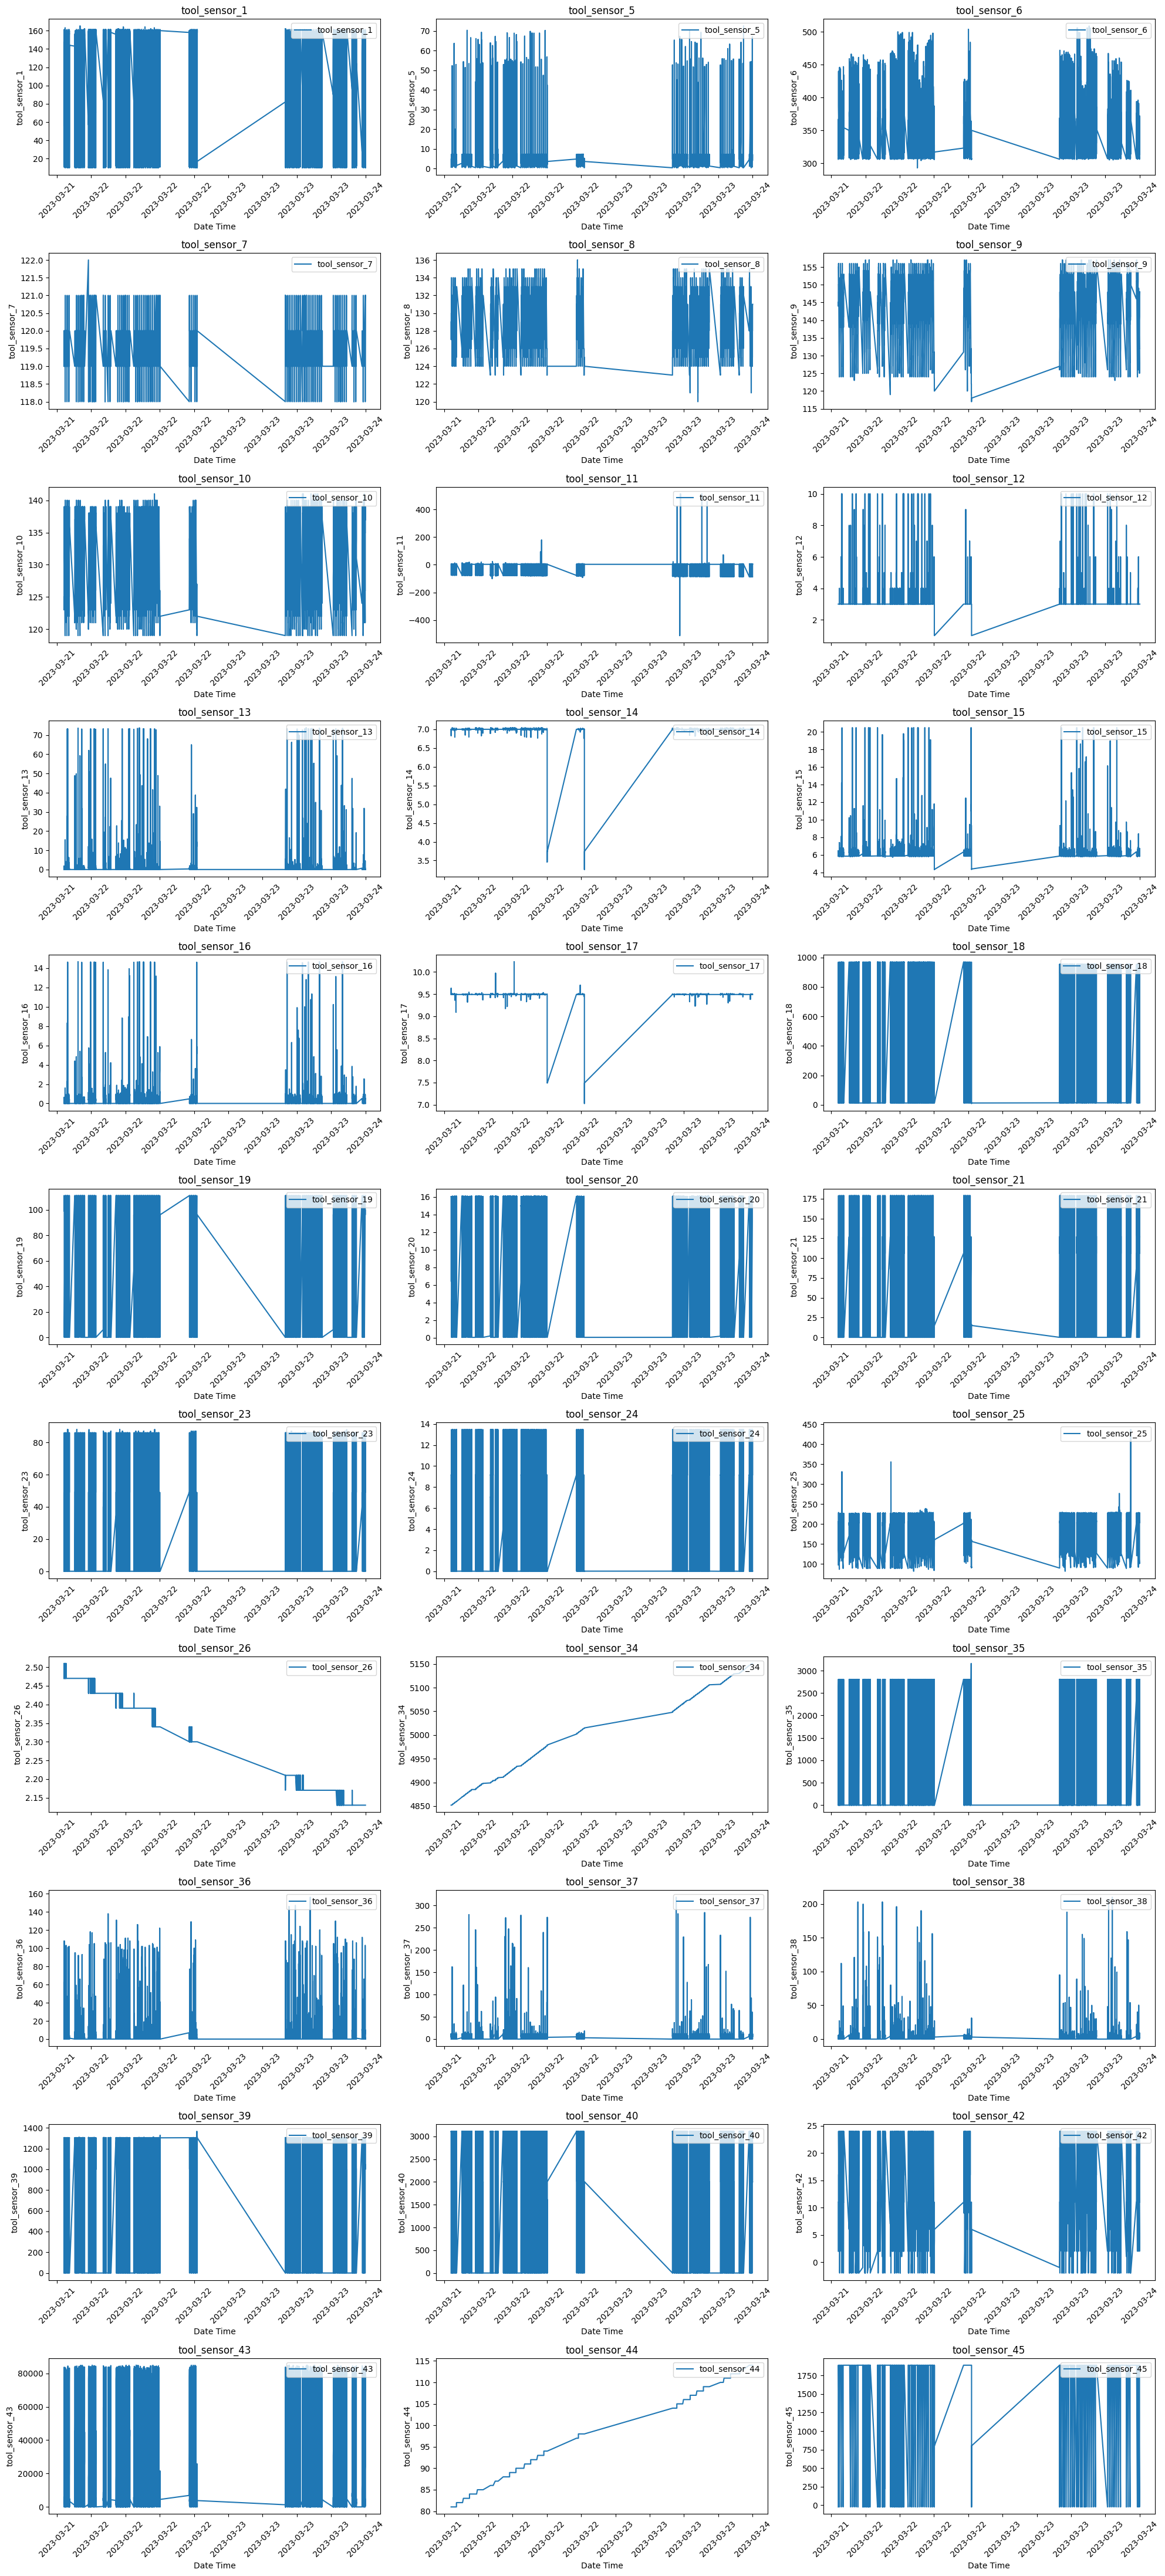

In [16]:
tool_sensor_columns = [col for col in df.columns if 'tool_sensor' in col]

num_sensors = len(tool_sensor_columns)
num_columns = 3
num_rows = (num_sensors // num_columns) + (num_sensors % num_columns > 0)

fig = plt.figure(figsize = (20, 4 * num_rows))

for i, sensor in enumerate(tool_sensor_columns, start = 1):
    ax = fig.add_subplot(num_rows, num_columns, i)
    ax.plot(df['timestamp'], df[sensor], label = sensor)
    ax.set_title(sensor)
    ax.set_xlabel('Date Time')
    ax.set_ylabel(sensor)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis = 'x', rotation = 45)
    ax.legend(loc = 'upper right')

plt.tight_layout()
plt.show()

2.2. Categorical Variable Analysis

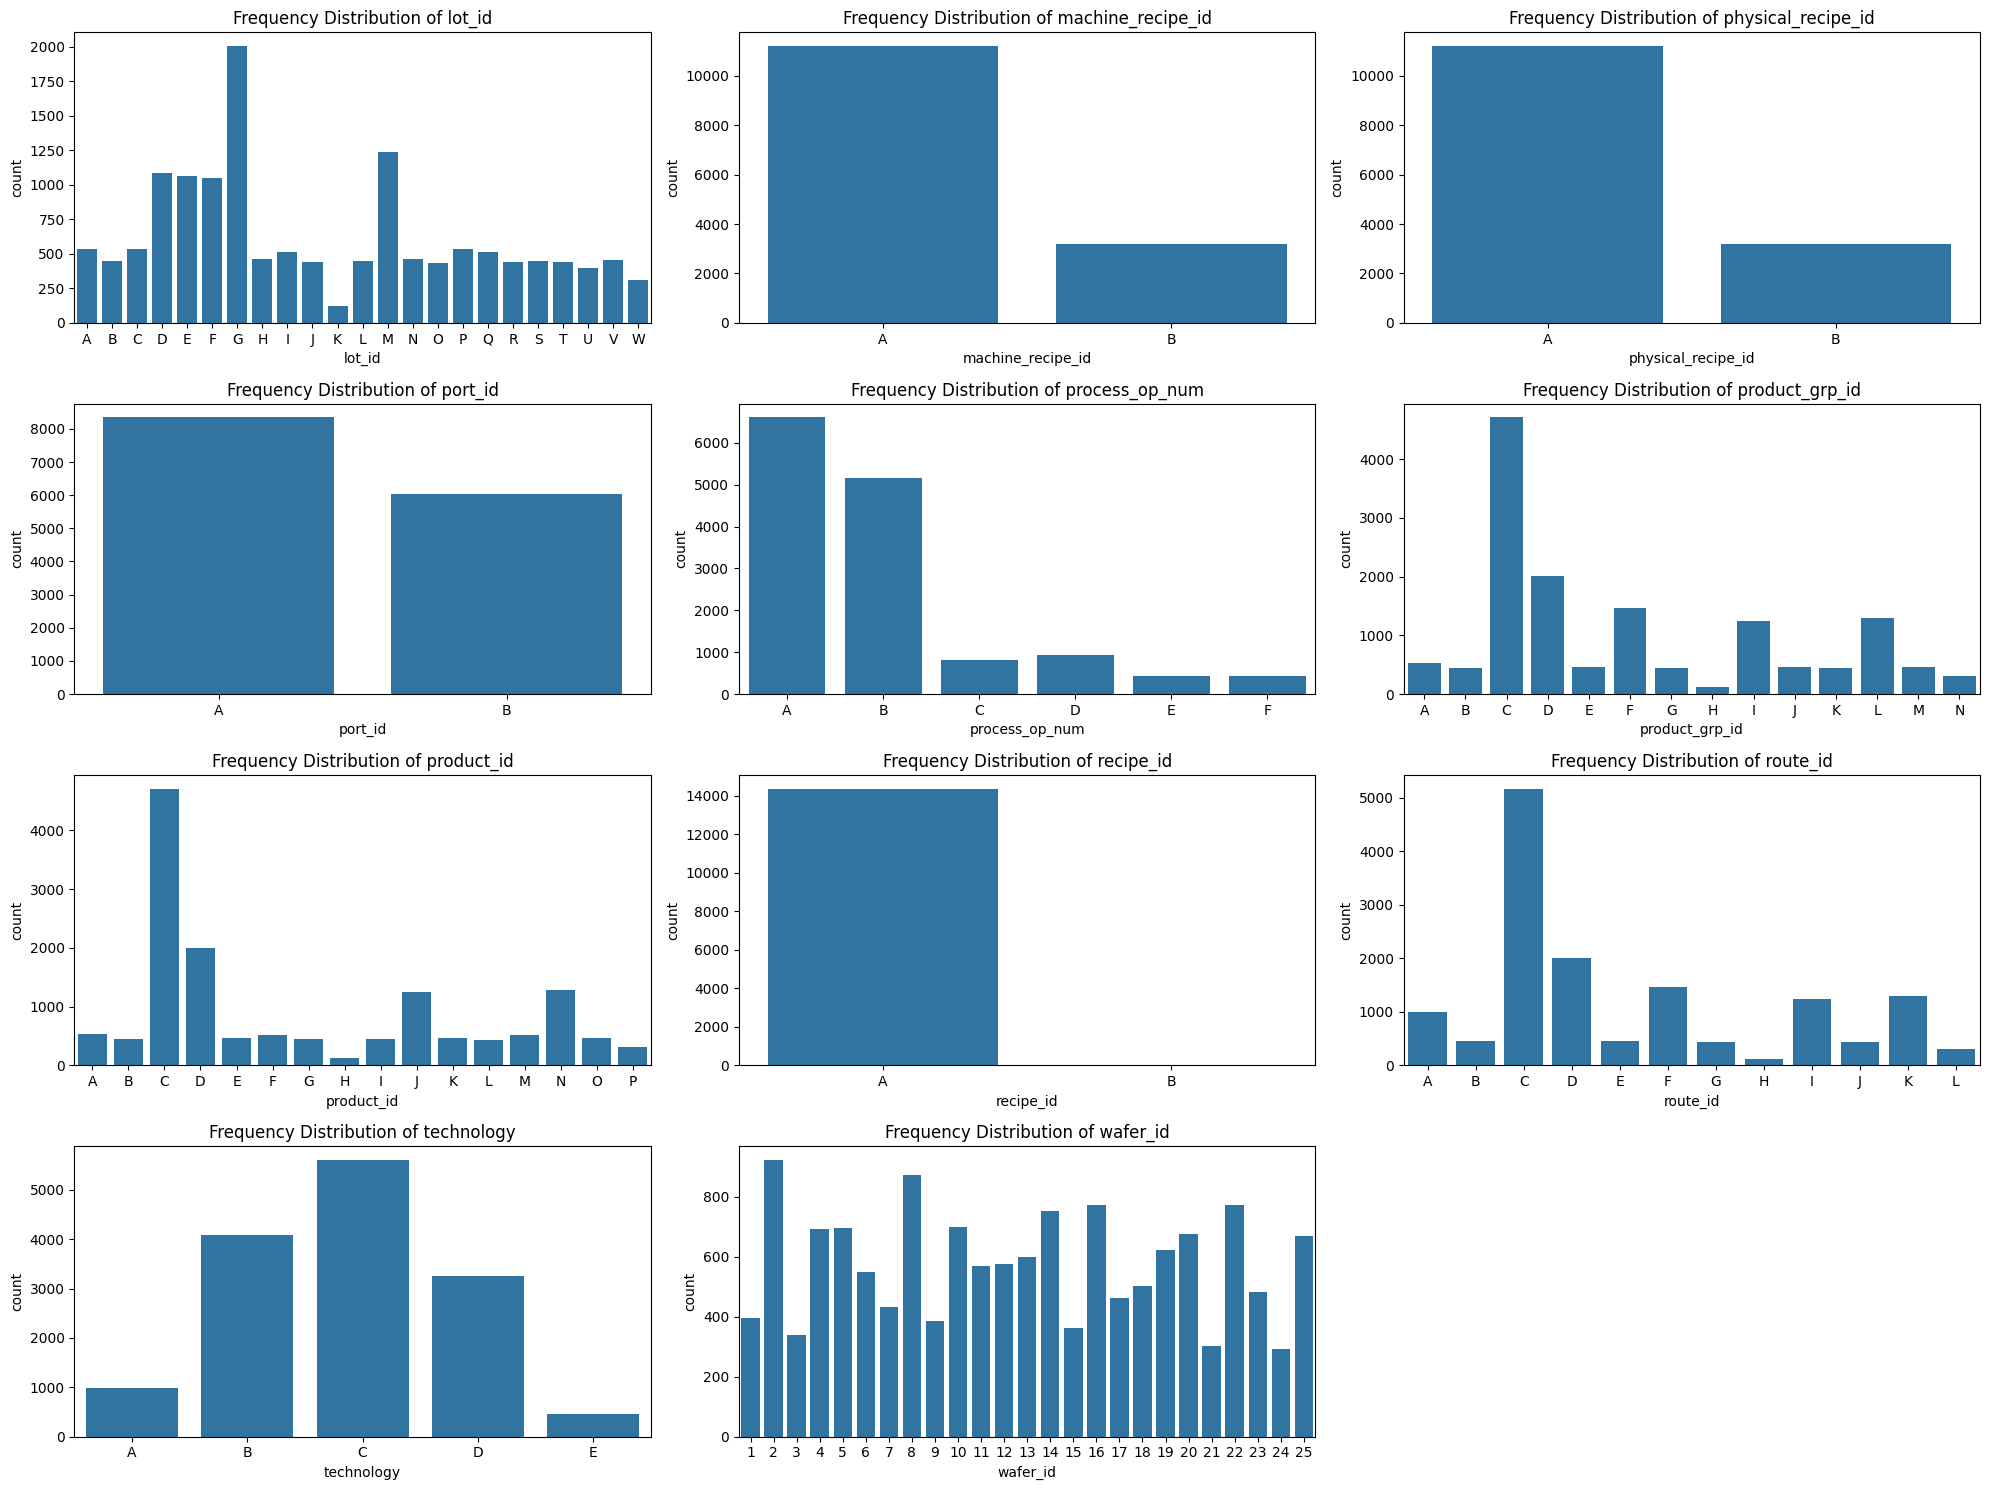

In [17]:
categorical_vars = ['lot_id', 'machine_recipe_id', 'physical_recipe_id', 'port_id', 'process_op_num', 
    'product_grp_id', 'product_id', 'recipe_id', 'route_id', 'technology', 'wafer_id']

plt.figure(figsize = (20, 15))

num_vars = len(categorical_vars)
num_cols = 3
num_rows = (num_vars // num_cols) + (num_vars % num_cols > 0)

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(x = var, data = df)
    plt.title(f'Frequency Distribution of {var}')

plt.tight_layout()
plt.show()

2.3. Relation Between Run, Run Start Time (Second) and Data Quality

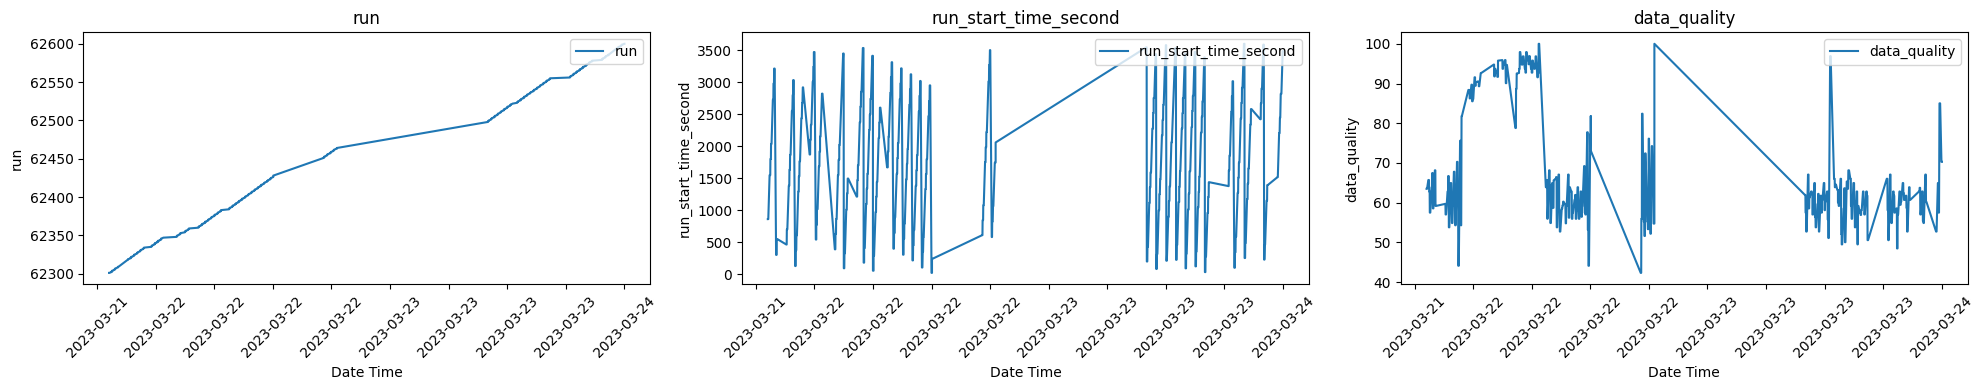

In [18]:
# convert run_start_time to seconds
df['run_start_time_second'] = pd.to_timedelta(df['run_start_time'].astype(str)).dt.total_seconds()

run_data = ['run', 'run_start_time_second', 'data_quality']
num_sensors = len(run_data)
num_columns = 3
num_rows = (num_sensors // num_columns) + (num_sensors % num_columns > 0)

fig = plt.figure(figsize = (20, 4 * num_rows))

for i, run in enumerate(run_data, start = 1):
    ax = fig.add_subplot(num_rows, num_columns, i)
    ax.plot(df['timestamp'], df[run], label = run)
    ax.set_title(run)
    ax.set_xlabel('Date Time')
    ax.set_ylabel(run)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis = 'x', rotation = 45)
    ax.legend(loc = 'upper right')

plt.tight_layout()
plt.show()

#### 3. Feature Engineering

In [19]:
# sort and drop unused time feature
df = df.sort_values(by='timestamp', ascending=False)
df = df.drop(columns=['timestamp', 'run', 'run_start_time', 'run_start_time_second'])

# initialize encoder
label_encoder = LabelEncoder()

# consider too many features, one hot encoding is not suitable
# encode categorical columns
categorical_cols = [
    'lot_id', 'machine_recipe_id', 'physical_recipe_id', 'port_id',
    'process_op_num', 'product_grp_id', 'product_id', 'recipe_id',
    'route_id', 'technology'
]

for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

numeric_cols = [col for col in df.columns if col not in categorical_cols]

# define columns= to drop from normalization
to_drop = ['wafer_id', 'calc_step_seq', 'calc_loop_seq']  

numeric_cols = [
    col for col in df.columns 
    if col not in categorical_cols and col not in to_drop
]

# initialize scaler
scaler = StandardScaler()

# fit-transform only the numeric column
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

#### 4. Feature Selection

Top correlated pairs > 0.9):
machine_recipe_id              physical_recipe_id              r=1.000
calc_step_seq                  calc_loop_seq                   r=1.000
tool_sensor_34                 tool_sensor_44                  r=0.999
tool_sensor_15                 tool_sensor_16                  r=0.995
tool_sensor_26                 tool_sensor_44                  r=-0.992
tool_sensor_26                 tool_sensor_34                  r=-0.991
recipe_id                      tool_sensor_14                  r=-0.989
tool_sensor_23                 tool_sensor_24                  r=0.987
tool_sensor_19                 tool_sensor_20                  r=0.980
tool_sensor_12                 tool_sensor_13                  r=0.980
tool_sensor_14                 tool_sensor_17                  r=0.979
lot_id                         tool_sensor_34                  r=0.978
lot_id                         tool_sensor_44                  r=0.976
tool_sensor_39                 tool_sensor_40

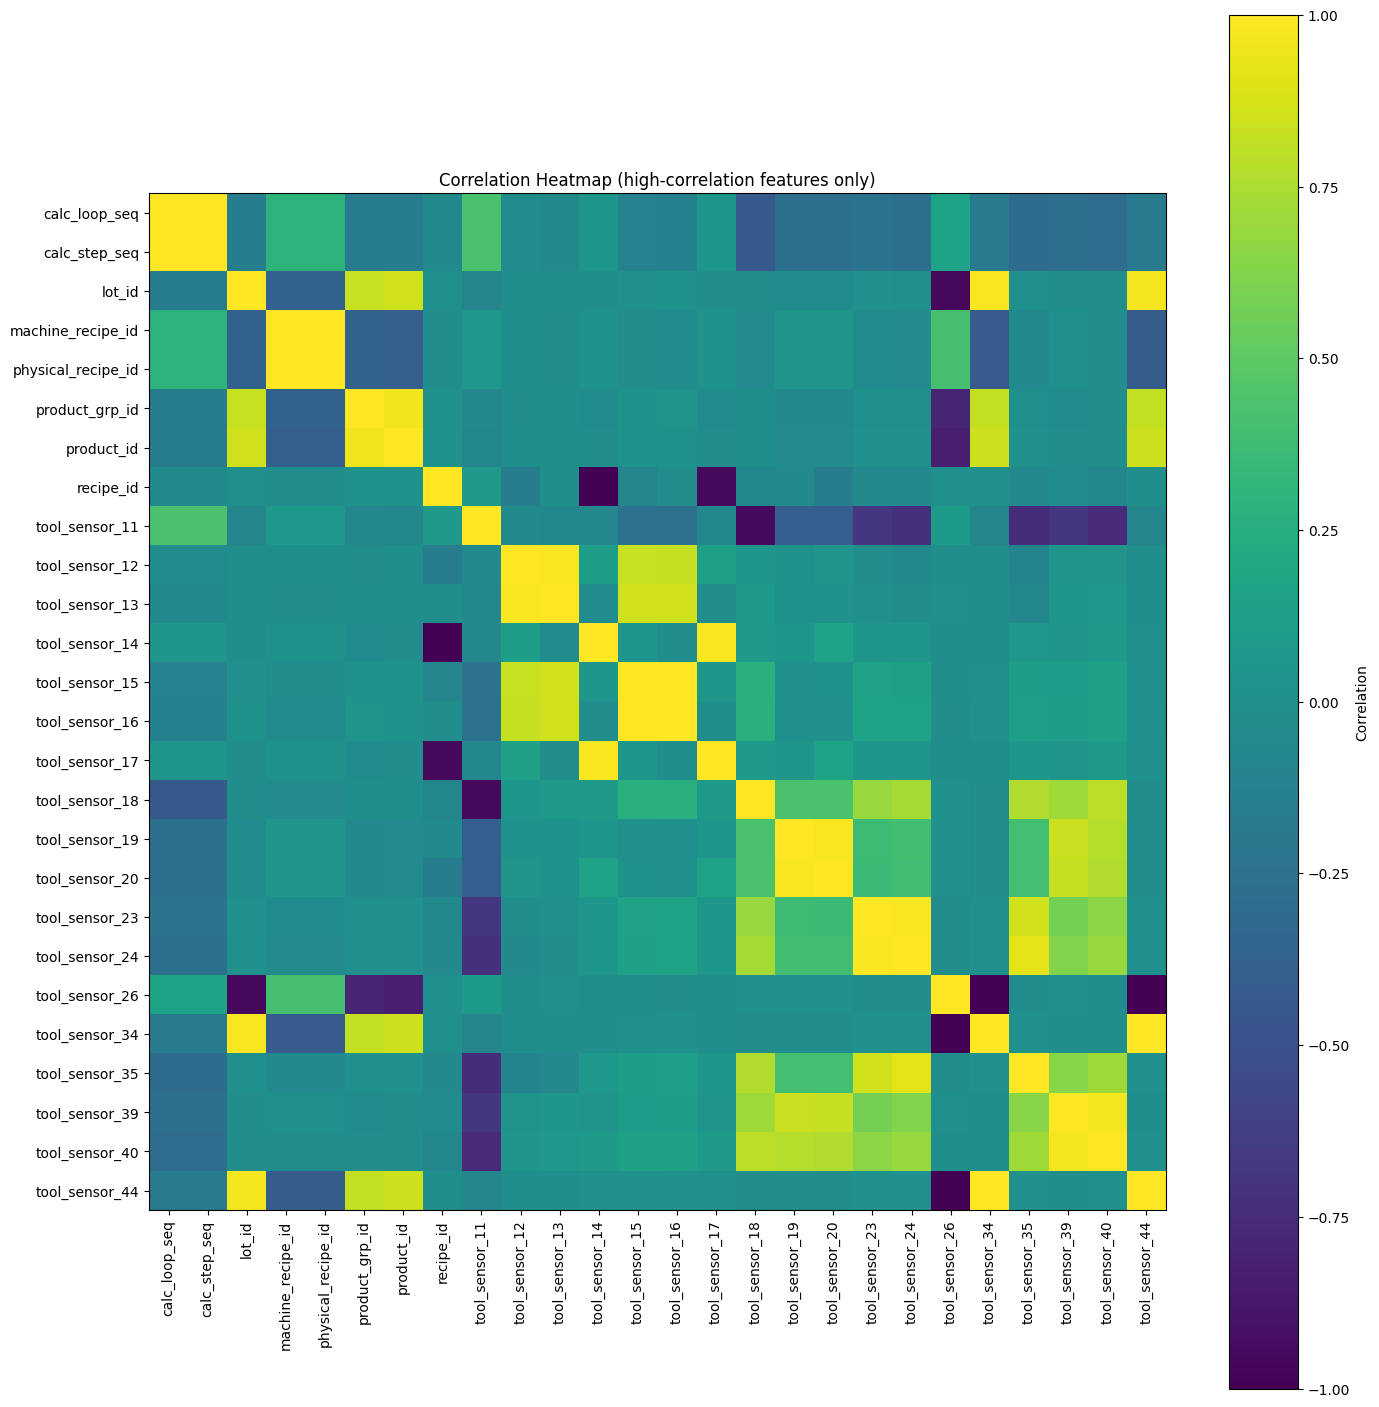

In [20]:
# pairwise correlation matrix (Pearson/Spearman)
corr = df.corr(numeric_only=True, method='pearson')

threshold = 0.9
pairs = []
cols = corr.columns

for i in range(len(cols)):
    for j in range(i):
        val = corr.iloc[i, j]
        if np.isfinite(val) and abs(val) > threshold:
            pairs.append((cols[j], cols[i], float(val)))

pairs_sorted = sorted(pairs, key=lambda x: -abs(x[2]))
if pairs_sorted:
    print(f"Top correlated pairs > {threshold}):")
    for a, b, v in pairs_sorted:
        print(f"{a:30s} {b:30s}  r={v:.3f}")
else:
    print(f"No pairs with > {threshold}.")

if pairs_sorted:
    involved = sorted(set([p[0] for p in pairs_sorted] + [p[1] for p in pairs_sorted]))
    sub = corr.loc[involved, involved]

    plt.figure(figsize=(min(20, 0.4*len(involved)+4), min(20, 0.4*len(involved)+4)))
    im = plt.imshow(sub, vmin=-1, vmax=1)
    plt.colorbar(im, label='Correlation')
    plt.xticks(range(len(involved)), involved, rotation=90)
    plt.yticks(range(len(involved)), involved)
    plt.title('Correlation Heatmap (high-correlation features only)')
    plt.tight_layout()
    plt.show()

to_drop = {p[1] for p in pairs_sorted}
df = df.drop(columns=to_drop)

#### 5. Hyperparameter Tuning

In [21]:
def flagged_rate(model, X):
    pred = model.predict(X) # -1 anomaly, 1 normal
    return (pred == -1).mean()

X_tr, X_val = train_test_split(df, test_size=0.25, random_state=42)

In [ ]:
if_grid = ParameterGrid({
    'n_estimators': [100, 200, 400],
    'max_samples': ['auto', 0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0],
    'bootstrap': [False, True],
    'contamination': [0.01, 0.02, 0.05, 0.1]
})

target_cont = 0.05
best, best_model = (np.inf, None), None

for p in if_grid:
    m = IsolationForest(random_state=42, **p).fit(X_tr)
    fr_train = flagged_rate(m, X_tr)
    fr_val   = flagged_rate(m, X_val)
    score = abs(fr_train - p['contamination']) * 2.0 + fr_val
    
    if score < best[0]:
        best = (score, p); best_model = m

# best_if = best_model
print("IF best params:", best[1])

IF best params: {'bootstrap': True, 'contamination': 0.01, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 200}


In [ ]:
oc_grid = ParameterGrid({
    'nu':    [0.01, 0.02, 0.05, 0.1],
    'gamma': ['scale'] + list(np.logspace(-4, 1, 6))
})

best_score, best_params, best_model = np.inf, None, None

for p in oc_grid:
    m = OneClassSVM(kernel='rbf', **p).fit(X_tr)
    fr_train = flagged_rate(m, X_tr)
    fr_val   = flagged_rate(m, X_val)
    score = abs(fr_train - p['nu']) * 2.0 + fr_val
    
    if score < best_score:
        best_score, best_params, best_model = score, p, m

# best_ocsvm = best_model
print("OCSVM best params:", best_params)

OCSVM best params: {'gamma': np.float64(0.001), 'nu': 0.01}


#### 6. Model Training

In [24]:
x_train, x_test = train_test_split(df, test_size=0.2, random_state=42)
x_train_result, x_test_result = x_train.copy(), x_test.copy()

In [25]:
# initialize isolation forest
if_model = IsolationForest(
    bootstrap=True,
    contamination=0.01,
    max_features=1.0,
    max_samples=0.5,
    n_estimators=200,
    random_state=42
)

# fit model
if_model.fit(x_train)

# predict anomaly (-1 = anomaly, 1 = normal)
x_train_result['ir_anomaly_result'] = if_model.predict(x_train)

# convert to binary flag (1 = anomaly, 0 = normal)
x_train_result['ir_anomaly_result'] = x_train_result['ir_anomaly_result'].map({1: 0, -1: 1})

In [26]:
# initialize one class svm
ocsvm_model = OneClassSVM(
    kernel='rbf',
    nu=0.02,
    gamma=0.1
)

# fit model
ocsvm_model.fit(x_train)

# predict anomaly (-1 = anomaly, 1 = normal)
x_train_result['ocsvm_anomaly_result'] = ocsvm_model.predict(x_train)

# convert to binary flag (1 = anomaly, 0 = normal)
x_train_result['ocsvm_anomaly_result'] = x_train_result['ocsvm_anomaly_result'].map({1: 0, -1: 1})

#### 7. Model Prediction

In [27]:
# isolation forest prediction on x_test
x_test_result['ir_anomaly_result'] = if_model.predict(x_test)
x_test_result['ir_anomaly_result'] = x_test_result['ir_anomaly_result'].map({1: 0, -1: 1})

# one class svm prediction on x_test
x_test_result['ocsvm_anomaly_result'] = ocsvm_model.predict(x_test)
x_test_result['ocsvm_anomaly_result'] = x_test_result['ocsvm_anomaly_result'].map({1: 0, -1: 1})

#### 8. Anomaly Detection

In [28]:
# calculate anomaly rate
anom_rate_ocsvm = x_test_result['ocsvm_anomaly_result'].mean() * 100
anom_rate_if = x_test_result['ir_anomaly_result'].mean() * 100

print(f"OCSVM anomaly rate: {anom_rate_ocsvm:.2f}%")
print(f"IF anomaly rate : {anom_rate_if:.2f}%")

OCSVM anomaly rate: 26.86%
IF anomaly rate : 0.94%


In [29]:
# rank by anomaly score
x_test_result['ocsvm_score'] = ocsvm_model.decision_function(x_test)
x_test_result['if_score']   = if_model.score_samples(x_test)

# sort lowest score, most anomalous first
top_anomalies_ocsvm = x_test_result.sort_values('ocsvm_score').head(20)
top_anomalies_iso   = x_test_result.sort_values('if_score').head(20)

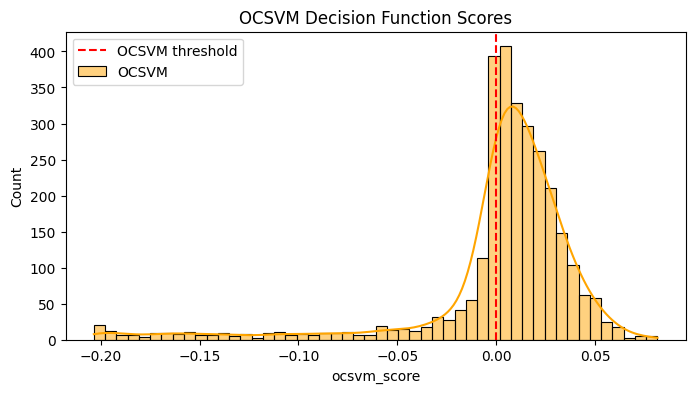

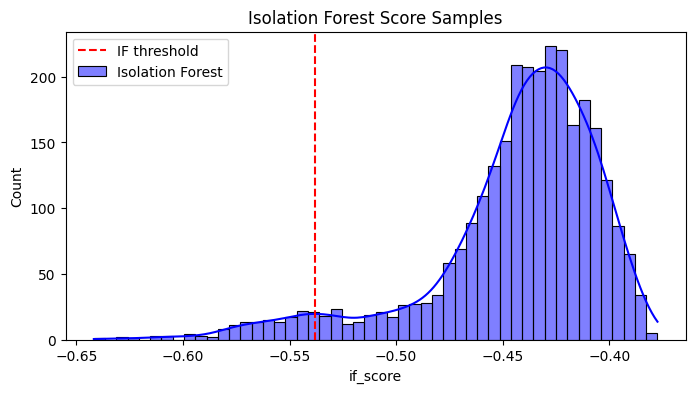

In [30]:
# visualization score distribution 
plt.figure(figsize=(8,4))
sns.histplot(x_test_result['ocsvm_score'], bins=50, kde=True, color='orange', label='OCSVM')
plt.axvline(0, color='red', linestyle='--', label='OCSVM threshold')
plt.legend()
plt.title('OCSVM Decision Function Scores')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(x_test_result['if_score'], bins=50, kde=True, color='blue', label='Isolation Forest')
plt.axvline(np.percentile(x_test_result['if_score'], 5), color='red', linestyle='--', label='IF threshold')
plt.legend()
plt.title('Isolation Forest Score Samples')
plt.show()

In [31]:
# consensus anomalies
x_test_result['consensus_anom'] = np.where(
    (x_test_result['ocsvm_anomaly_result'] == 1) & (x_test_result['ir_anomaly_result'] == 1), 1, 0
)

print(f"Consensus anomalies: {x_test_result['consensus_anom'].sum()} runs")

Consensus anomalies: 24 runs


In [43]:
numeric_cols = [col for col in numeric_cols if col not in to_drop]

# inspect top anomalies
print("Top OCSVM anomalies:")
print(top_anomalies_ocsvm[numeric_cols].head())

print("Top IF anomalies:")
print(top_anomalies_iso[numeric_cols].head())

Top OCSVM anomalies:
       data_quality  tool_sensor_1  tool_sensor_5  tool_sensor_6  \
7180      -0.742429       0.768480      -0.426355       1.874921   
13582     -0.375417       0.695606      -0.295427      -1.609060   
10703      1.656819       0.240142       0.821944      -0.972563   
10237     -0.578323      -0.160666      -0.489128       3.650411   
9672      -0.510900       0.786699      -0.248795      -1.676059   

       tool_sensor_7  tool_sensor_8  tool_sensor_9  tool_sensor_10  \
7180        0.519211       1.739488       1.312142        0.836503   
13582      -0.729812      -1.626403      -2.198921       -1.908071   
10703       0.519211      -1.626403      -2.312181       -1.908071   
10237       0.519211       0.729721       0.292801        0.997948   
9672       -1.978835      -1.626403      -1.972400       -1.585180   

       tool_sensor_11  tool_sensor_12  tool_sensor_15  tool_sensor_19  \
7180         2.014153       -0.073687       -0.579085       -4.397709   
135

#### 9. Model Explainability (Optional)

 99%|===================| 2857/2878 [02:21<00:01]        C:\Users\tellw\AppData\Local\Temp\ipykernel_19992\2410851807.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(if_shap_values, x_test)


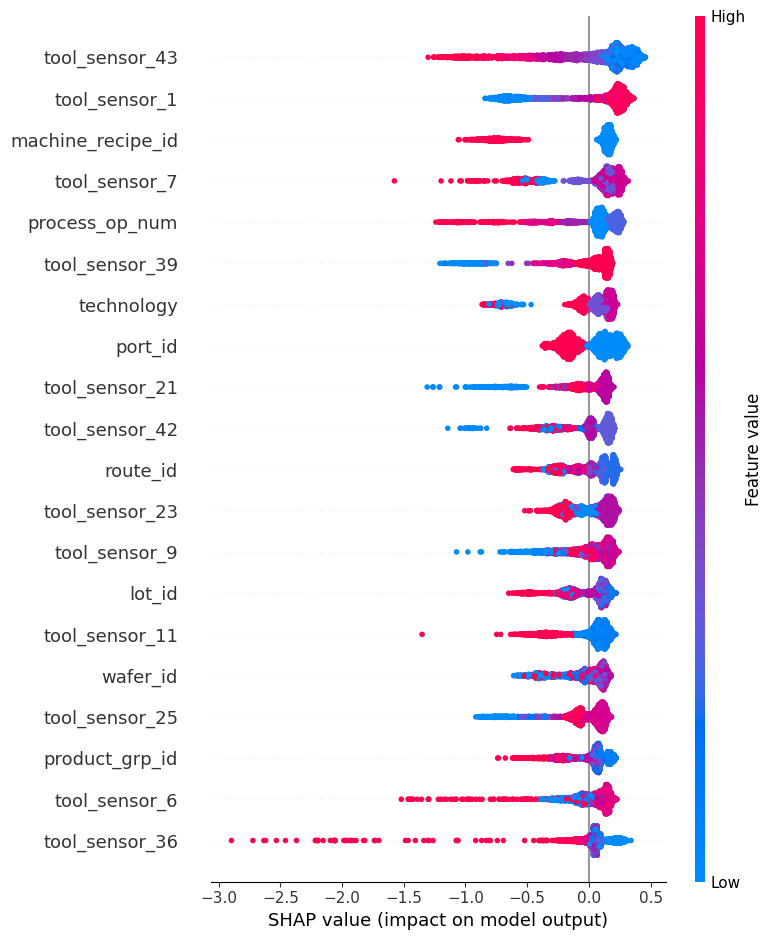

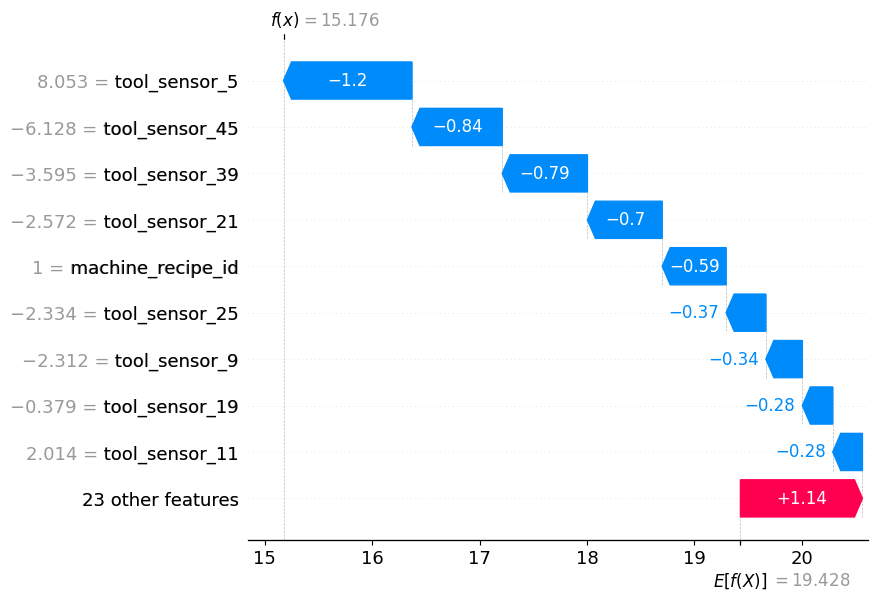

PermutationExplainer explainer:   2%|▏         | 50/2878 [09:34<9:26:15, 12.01s/it] 

In [ ]:
# SHAP for Isolation Forest
if_explainer = shap.Explainer(if_model, x_train)
if_shap_values = if_explainer(x_test)

# Global importance plot
shap.summary_plot(if_shap_values, x_test)

# Local explanation for first test sample
shap.plots.waterfall(if_shap_values[0])

# SHAP for One-Class SVM
oc_explainer = shap.Explainer(ocsvm_model.decision_function, x_train)
oc_shap_values = oc_explainer(x_test)

# Global importance plot
shap.summary_plot(oc_shap_values, x_test)

# Local explanation
shap.plots.waterfall(oc_shap_values[0])